In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(r'C:\Users\NAVEEN\Desktop\IRTA\Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [5]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [6]:
df.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,4.100000e+01,16115.000000,28332.000000
mean,1.840066e+08,0.529321,4.514048
std,2.337036e+07,9.345017,0.934957
min,1.116244e+08,0.000000,1.000000
25%,1.843344e+08,0.000000,4.000000
50%,1.885078e+08,0.000000,5.000000
75%,1.988160e+08,0.000000,5.000000
max,2.085304e+08,621.000000,5.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

In [8]:
df["asins"].unique()   #unique products

array(['B00QWO9P0O,B00LH3DMUO', 'B00DIHVMEA,B00EZ1ZTV0',
       'B01E6AO69U,B00L9EPT8O', 'B01J24C0TI', 'B073SQYXTW', 'B00ZV9RDKK',
       'B00QWO9P0O,B01IB83NZG,B00MNV8E0C', 'B00WRDS8H0',
       'B00EEBS9O0,B01CHQHIJK', 'B01B66989K,B00CD8ADKO,B00LA9H6UM',
       'B00DUGZFWY', 'B00F5CKWBA,B00KPQCWAU',
       'B0002LCUZK,B010CEC6MI,B01B25NN64', 'B074MCBG25,B075357QFB',
       'B00QFQRELG', 'B006GWO7UA', 'B01L7XWEQQ', 'B006BGZJJ4',
       'B00Y3QOH5G', 'B01BH83OOM', 'B00ZV9PXP2', 'B00NH144GK,B00LA9H1E8',
       'B00OP6SMCI', 'B00BGIQS1A', 'B006LW0W5Y', 'B0751RGYJV',
       'B00IOY8XWQ', 'B010RLCH2U', 'B01GAGYVU2', 'B0752151W6',
       'B018SZT3BK,B01AHB9CN2', 'B018Y226XO', 'B01AHB9CYG', 'B01ACEKAJY',
       'B00REQKWGA', 'B00IOYAM4I', 'B01IO618J8', 'B018Y22BI4',
       'B01AHBBG04', 'B01AHBDCKQ', 'B00VINDBJK',
       'B0189XZRTI,B0189XYY0Q,B0189XZ0KY', 'B01J94SWWU', 'B00QAVO43C',
       'B06VTJWRJW', 'B00QAVNWSK', 'B01J94SCAM', 'B01J94SBEY',
       'B01J94YIT6', 'B01J94T1Z2', 'B018Y224PY'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028B375B3448>,
      dtype=object)

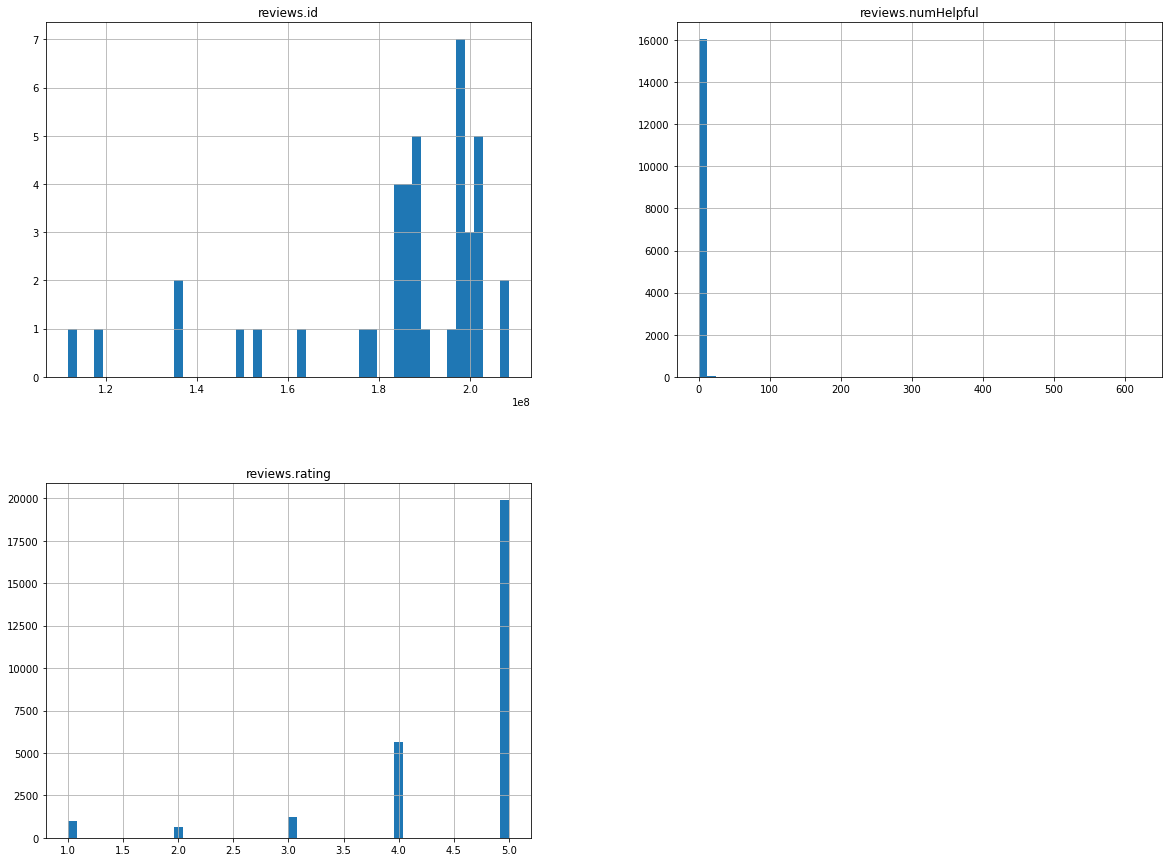

In [9]:
df.hist(bins=50, figsize=(20,15))

In [10]:
print("Before {}".format(len(df)))
dataAfter = df.dropna(subset=["reviews.rating"])
# Removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)

Before 28332
After 28332


In [11]:
#already preprocessed?

In [12]:
df["reviews.rating"].value_counts()/len(df)   #percentage of ratings

5    0.702280
4    0.199351
3    0.042567
1    0.034060
2    0.021742
Name: reviews.rating, dtype: float64

In [13]:
reviews = df.copy()

In [14]:
reviews.groupby("asins")["name"].unique()

asins
B0002LCUZK,B010CEC6MI,B01B25NN64    [Expanding Accordion File Folder Plastic Porta...
B001NIZB5M                          [Amazon Kindle Replacement Power Adapter (Fits...
B005OOKNP4                          [AmazonBasics Bluetooth Keyboard for Android D...
B006BGZJJ4                          [Amazon Kindle Charger Power Adapter Wall Char...
B006GWO7UA                          [Kindle PowerFast International Charging Kit (...
                                                          ...                        
B06XD5YCKX                          [All-New Kindle Oasis E-reader - 7 High-Resolu...
B073SQYXTW                                               [Echo Spot Pair Kit (Black)]
B074MCBG25,B075357QFB               [Cat Litter Box Covered Tray Kitten Extra Larg...
B0751RGYJV                          [Amazon Echo (2nd Generation) Smart Assistant ...
B0752151W6                          [All-new Echo (2nd Generation) with improved s...
Name: name, Length: 65, dtype: object

In [15]:
%matplotlib inline 

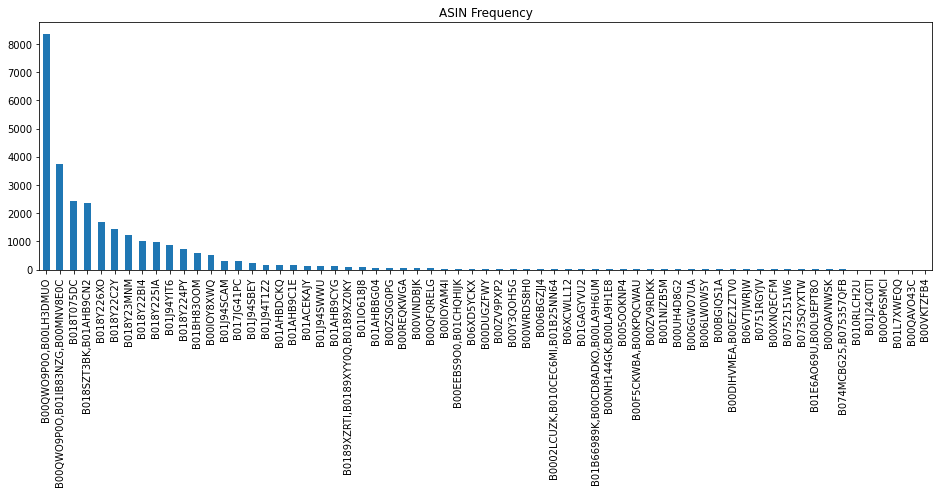

In [16]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
#ax2 = plt.subplot(212, sharex = ax1)
reviews["asins"].value_counts().plot(kind="bar", ax=ax1, title="ASIN Frequency")

In [20]:
corr_matrix = reviews.corr()
corr_matrix
# Here we can analyze reviews.ratings with asins

,reviews.id,reviews.numHelpful,reviews.rating
reviews.id,1.000000,-0.553529,0.074941
reviews.numHelpful,-0.553529,1.000000,-0.041006
reviews.rating,0.074941,-0.041006,1.000000


In [21]:
counts = reviews["asins"].value_counts().to_frame()
counts.head()

,asins
"B00QWO9P0O,B00LH3DMUO",8343
"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",3728
B018T075DC,2443
"B018SZT3BK,B01AHB9CN2",2370
B018Y226XO,1676


In [22]:
avg_rating = reviews.groupby("asins")["reviews.rating"].mean().to_frame()
avg_rating.head()

,reviews.rating
asins,
"B0002LCUZK,B010CEC6MI,B01B25NN64",5.000000
B001NIZB5M,2.800000
B005OOKNP4,4.333333
B006BGZJJ4,4.666667
B006GWO7UA,4.800000


In [23]:
table = counts.join(avg_rating)
table.head(30)

,asins,reviews.rating
"B00QWO9P0O,B00LH3DMUO",8343,4.448040
"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",3728,4.453594
B018T075DC,2443,4.597217
"B018SZT3BK,B01AHB9CN2",2370,4.584388
B018Y226XO,1676,4.531026
B018Y22C2Y,1425,4.534035
B018Y23MNM,1212,4.534653
B018Y22BI4,1024,4.506836
B018Y225IA,987,4.511651
B01J94YIT6,883,4.578709


,asins,reviews.rating
asins,1.000000,0.021024
reviews.rating,0.021024,1.000000


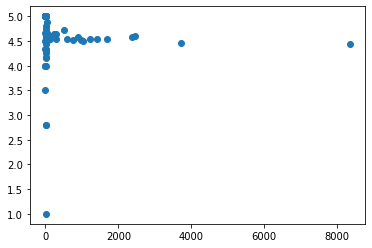

In [24]:
plt.scatter("asins", "reviews.rating", data=table)
table.corr()
